In [1]:
import pandas as pd
import pywt
from sklearn.cluster import KMeans
import numpy as np


In [3]:
data= pd.read_csv('full_lv100_0801_ad.csv',encoding='utf-8')
binge_df= pd.read_csv('new_binge.csv',encoding='cp949')
binge_df=binge_df[['player_slug','binge']]

## LOESS 방식 사용(Lv 100)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

data= pd.read_csv('full_lv100_0801_ad.csv',encoding='utf-8')
irrelevant_columns = ['total_ad', 'total_purchase']
relevant_columns = [col for col in data.columns if col not in irrelevant_columns]
curves_data = data[relevant_columns].iloc[:, 1:100].values  # 2번 열부터 100번 열까지


c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


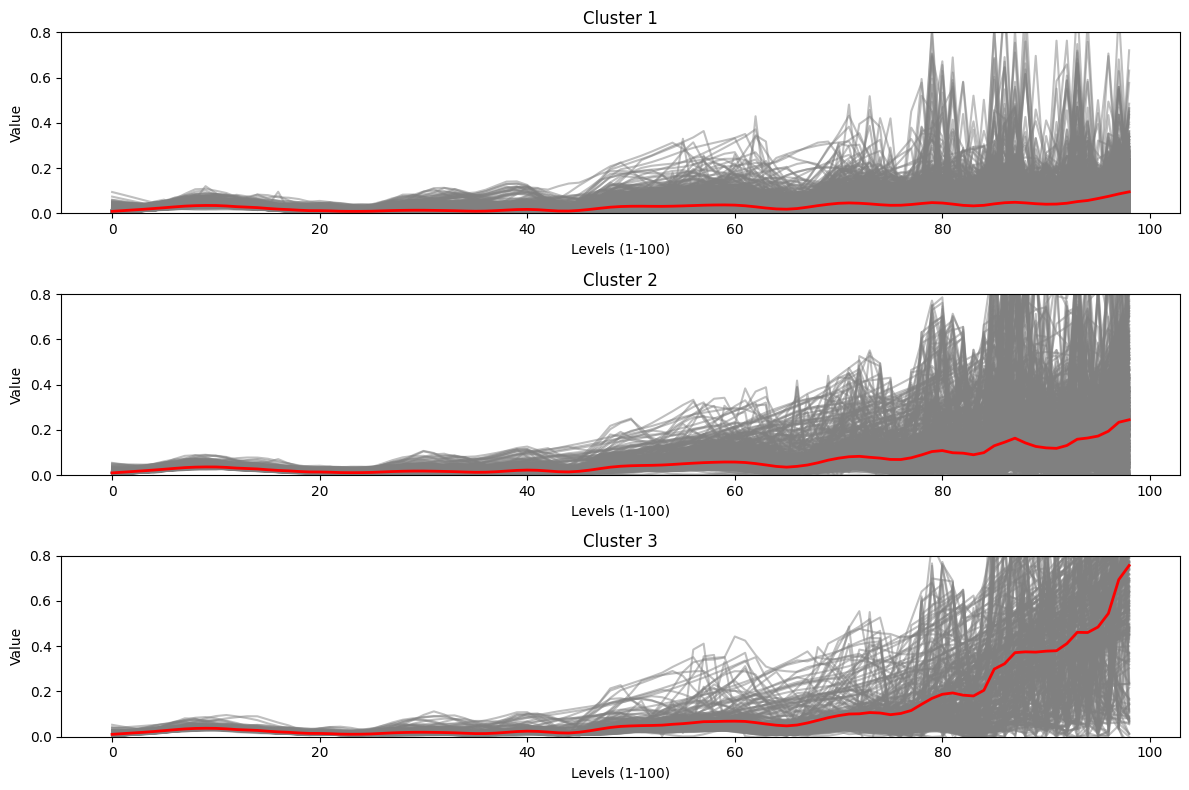

In [5]:
# LOESS 적용 함수 정의
def apply_loess(curve, frac=0.1):
    """
    curve: 원본 곡선 데이터 (1차원 배열)
    frac: LOESS에서 사용하는 로컬 윈도우 크기 (0에서 1 사이의 값)
    """
    x = np.arange(len(curve))  # x축 데이터 포인트 생성 (1, 2, 3, ..., N)
    loess_result = sm.nonparametric.lowess(curve, x, frac=frac)  # LOESS 적용
    return loess_result[:, 1]  # 평활화된 y값 반환

# 각 곡선에 LOESS 적용
loess_curves = np.array([apply_loess(curve, frac=0.1) for curve in curves_data])

# KMeans 클러스터링 수행
kmeans = KMeans(n_clusters=3, random_state=42)
labels_loess = kmeans.fit_predict(loess_curves)
data['cluster'] = labels_loess

# 클러스터 결과 시각화
plt.figure(figsize=(12, 8))

for cluster in range(3):  # 각 클러스터에 대해 반복
    plt.subplot(3, 1, cluster + 1)
    for curve in loess_curves[labels_loess == cluster]:  # 해당 클러스터의 곡선들을 그리기
        plt.plot(curve, color='gray', alpha=0.5)
    plt.plot(loess_curves[labels_loess == cluster].mean(axis=0), color='red', linewidth=2)  # 평균 곡선
    plt.title(f'Cluster {cluster + 1}')
    plt.xlabel('Levels (1-100)')
    plt.ylabel('Value')
    plt.ylim(0, 0.8)  # 필요시 Y축 범위 조정

plt.tight_layout()
plt.show()

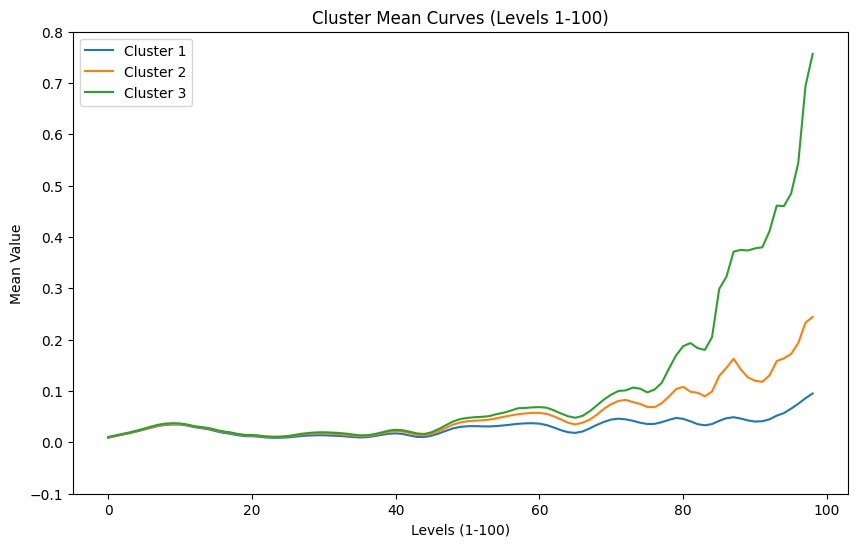

In [6]:
# 클러스터별 평균 곡선을 하나의 그래프로 시각화
plt.figure(figsize=(10, 6))

for cluster in range(3):  # 각 클러스터에 대해 반복
    mean_curve = loess_curves[labels_loess == cluster].mean(axis=0)
    plt.plot(mean_curve, label=f'Cluster {cluster + 1}')

plt.title('Cluster Mean Curves (Levels 1-100)')
plt.xlabel('Levels (1-100)')
plt.ylabel('Mean Value')
plt.ylim(-0.1, 0.8)  # 필요시 Y축 범위 조정
plt.legend()
plt.show()

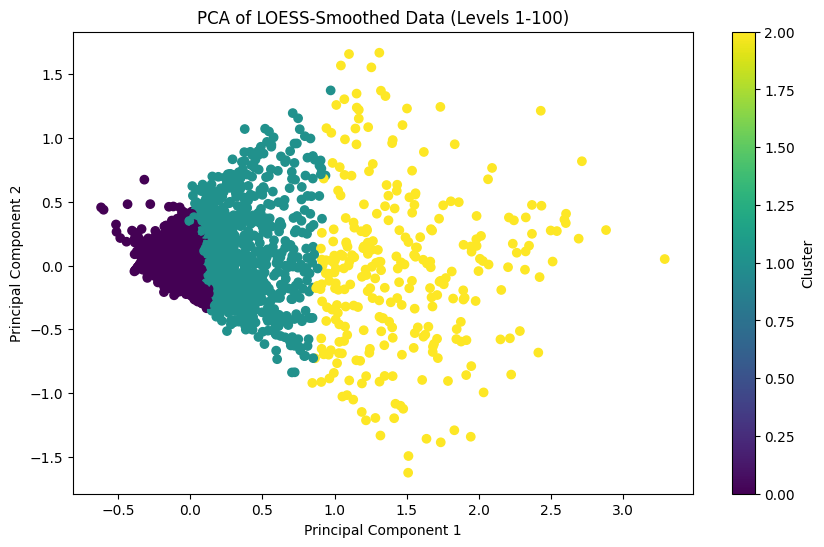

Explained Variance by Component 1: 0.49
Explained Variance by Component 2: 0.15


In [7]:
# PCA 분석 수행
pca = PCA(n_components=2)
pca_result = pca.fit_transform(loess_curves)

# PCA 결과 시각화 (클러스터별)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels_loess, cmap='viridis')
plt.title('PCA of LOESS-Smoothed Data (Levels 1-100)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

# PCA 설명력 (Variance Explained)
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by Component 1: {explained_variance[0]:.2f}")
print(f"Explained Variance by Component 2: {explained_variance[1]:.2f}")

In [8]:
df_unique = binge_df.drop_duplicates(subset=['player_slug'])
df_unique
merged_df = data.merge(df_unique, on='player_slug', how='left')
merged_df
# Cluster별로 그룹화하여 'binge' 열의 비율을 계산
binge_ratios = merged_df.groupby('cluster')['binge'].value_counts(normalize=True).unstack()

# 결과 확인
print(binge_ratios)
binge_number = merged_df.groupby('cluster')['binge'].value_counts().unstack()

# 결과 확인
print(binge_number)

binge           0         1
cluster                    
0        0.495403  0.504597
1        0.462087  0.537913
2        0.359155  0.640845
binge       0     1
cluster            
0        2910  2964
1         518   603
2         102   182


In [9]:
data

,player_slug,2,3,4,5,6,7,8,9,10,...,94,95,96,97,98,99,100,total_ad,total_purchase,cluster
0,2021-11-01T08:32:01.518Z,0.019444,0.004167,0.009444,0.015833,0.015278,0.020833,0.026667,0.034167,0.044722,...,0.115556,0.152222,0.003333,0.003889,0.132667,0.906944,0.914500,0.0,0.0,1
1,2021-11-01T10:41:53.949Z,0.020556,0.004167,0.006111,0.006667,0.019722,0.021389,0.023056,0.030278,0.032778,...,0.123833,0.095833,0.157500,0.002500,0.127944,0.401944,0.514722,28.0,0.0,1
2,2021-11-01T14:12:34.729Z,0.015833,0.004444,0.030278,0.013889,0.028056,0.020000,0.021389,0.026389,0.032778,...,0.011667,0.064500,0.351111,0.041611,0.111389,0.002222,0.001944,0.0,0.0,0
3,2021-11-01T15:01:02.831Z,0.007778,0.003056,0.006389,0.009722,0.012500,0.049722,0.070833,0.036222,0.032500,...,0.043944,0.236111,0.036111,0.002778,0.126667,0.121111,0.135556,0.0,0.0,0
4,2021-11-01T15:10:02.121Z,0.006944,0.003611,0.010833,0.015000,0.023056,0.022778,0.022500,0.048333,0.031667,...,0.004167,0.199111,0.065222,0.024167,0.003333,0.070611,0.250556,2.0,3300.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7274,2022-03-28T00:01:33.666Z,0.006667,0.003333,0.008333,0.013889,0.019444,0.021667,0.021111,0.024722,0.030278,...,0.021389,0.090556,0.083333,0.002222,0.002222,0.036444,0.600833,2.0,3300.0,0
7275,2022-03-28T07:44:40.201Z,0.006944,0.003056,0.005833,0.012500,0.012500,0.021667,0.021389,0.027222,0.036944,...,0.674444,0.759722,0.876389,0.136778,0.171667,0.043056,0.067500,0.0,0.0,1
7276,2022-03-28T11:06:23.113Z,0.006389,0.005278,0.012222,0.021944,0.031389,0.026667,0.024722,0.033889,0.035556,...,0.020278,0.081389,0.080000,0.002778,0.002778,0.071167,0.149722,0.0,122100.0,0
7277,2022-03-29T09:29:33.653Z,0.031389,0.031111,0.047222,0.029722,0.037778,0.020556,0.023778,0.026111,0.032222,...,0.046389,0.049167,0.002778,0.002778,0.023444,0.093333,0.102778,6.0,0.0,0


## LOESS 클러스터(Lv50)

In [11]:
irrelevant_columns = ['total_ad', 'total_purchase','cluster'] #100레벨 까지 했을때의 클러스터 따로 저장
relevant_columns = [col for col in data.columns if col not in irrelevant_columns]
curves_data = data[relevant_columns].iloc[:, 1:50].values  # 2번 열부터 100번 열까지


c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


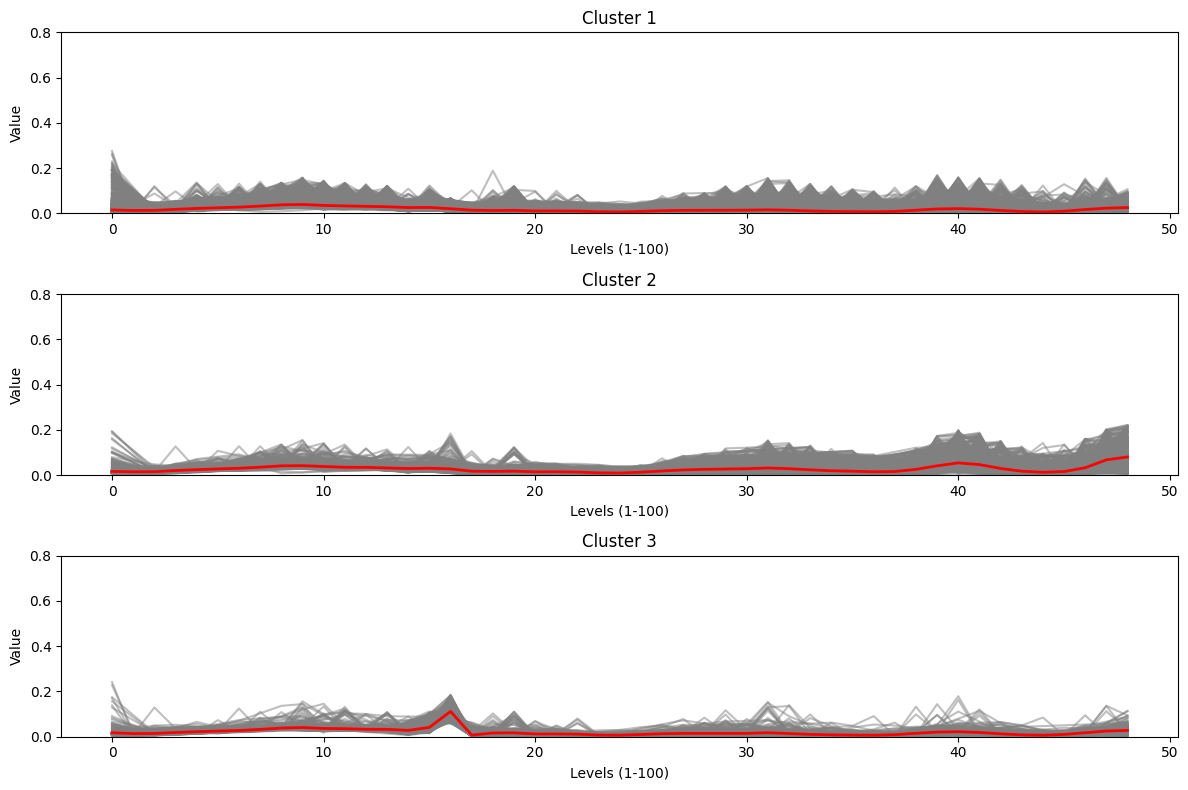

In [13]:
# LOESS 적용 함수 정의
def apply_loess(curve, frac=0.1):
    """
    curve: 원본 곡선 데이터 (1차원 배열)
    frac: LOESS에서 사용하는 로컬 윈도우 크기 (0에서 1 사이의 값)
    """
    x = np.arange(len(curve))  # x축 데이터 포인트 생성 (1, 2, 3, ..., N)
    loess_result = sm.nonparametric.lowess(curve, x, frac=frac)  # LOESS 적용
    return loess_result[:, 1]  # 평활화된 y값 반환

# 각 곡선에 LOESS 적용
loess_curves = np.array([apply_loess(curve, frac=0.1) for curve in curves_data])

# KMeans 클러스터링 수행
kmeans = KMeans(n_clusters=3, random_state=42)
labels_loess = kmeans.fit_predict(loess_curves)
data['Lv_50_cluster'] = labels_loess

# 클러스터 결과 시각화
plt.figure(figsize=(12, 8))

for cluster in range(3):  # 각 클러스터에 대해 반복
    plt.subplot(3, 1, cluster + 1)
    for curve in loess_curves[labels_loess == cluster]:  # 해당 클러스터의 곡선들을 그리기
        plt.plot(curve, color='gray', alpha=0.5)
    plt.plot(loess_curves[labels_loess == cluster].mean(axis=0), color='red', linewidth=2)  # 평균 곡선
    plt.title(f'Cluster {cluster + 1}')
    plt.xlabel('Levels (1-100)')
    plt.ylabel('Value')
    plt.ylim(0, 0.8)  # 필요시 Y축 범위 조정

plt.tight_layout()
plt.show()

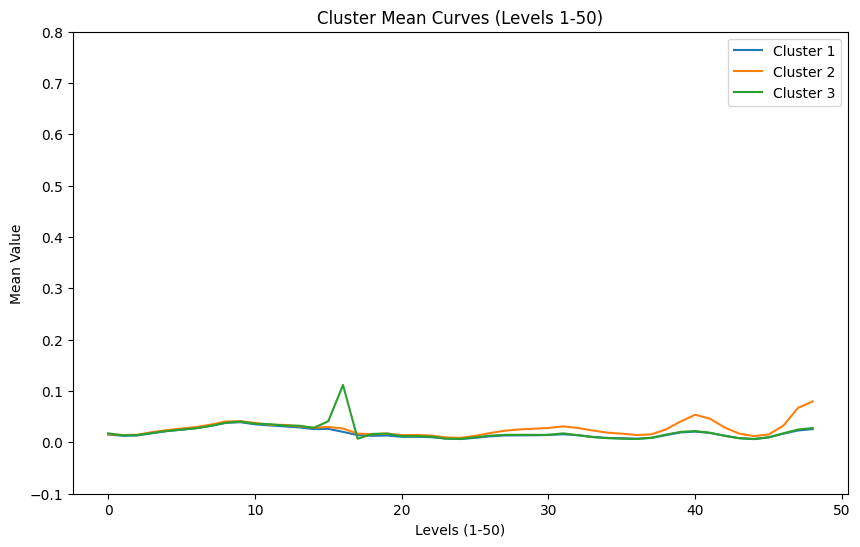

In [14]:
# 클러스터별 평균 곡선을 하나의 그래프로 시각화
plt.figure(figsize=(10, 6))

for cluster in range(3):  # 각 클러스터에 대해 반복
    mean_curve = loess_curves[labels_loess == cluster].mean(axis=0)
    plt.plot(mean_curve, label=f'Cluster {cluster + 1}')

plt.title('Cluster Mean Curves (Levels 1-50)')
plt.xlabel('Levels (1-50)')
plt.ylabel('Mean Value')
plt.ylim(-0.1, 0.8)  # 필요시 Y축 범위 조정
plt.legend()
plt.show()

In [16]:
df_unique = binge_df.drop_duplicates(subset=['player_slug'])
df_unique
merged_df = data.merge(df_unique, on='player_slug', how='left')
merged_df
# Cluster별로 그룹화하여 'binge' 열의 비율을 계산
binge_ratios = merged_df.groupby('Lv_50_cluster')['binge'].value_counts(normalize=True).unstack()

# 결과 확인
print(binge_ratios)
binge_number = merged_df.groupby('Lv_50_cluster')['binge'].value_counts().unstack()

# 결과 확인
print(binge_number)

binge                 0         1
Lv_50_cluster                    
0              0.482342  0.517658
1              0.482044  0.517956
2              0.536723  0.463277
binge             0     1
Lv_50_cluster            
0              2991  3210
1               349   375
2               190   164


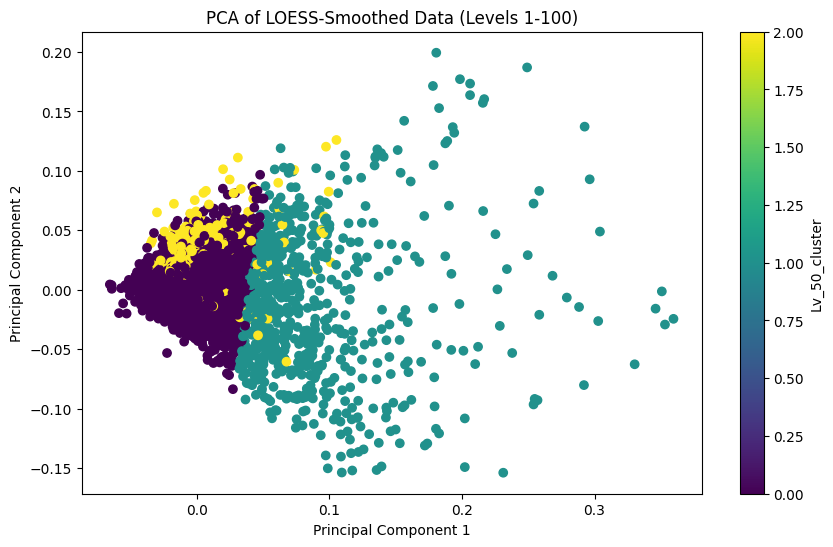

Explained Variance by Component 1: 0.20
Explained Variance by Component 2: 0.09


In [17]:
# PCA 분석 수행
pca = PCA(n_components=2)
pca_result = pca.fit_transform(loess_curves)

# PCA 결과 시각화 (클러스터별)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels_loess, cmap='viridis')
plt.title('PCA of LOESS-Smoothed Data (Levels 1-50)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Lv_50_cluster')
plt.show()

# PCA 설명력 (Variance Explained)
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by Component 1: {explained_variance[0]:.2f}")
print(f"Explained Variance by Component 2: {explained_variance[1]:.2f}")

## Wavelet 방식으로 적용(Lv100)

In [18]:
data= pd.read_csv('full_lv100_0801_ad.csv',encoding='utf-8')
binge_df= pd.read_csv('new_binge.csv',encoding='cp949')
binge_df=binge_df[['player_slug','binge']]

In [21]:
# 웨이블릿 변환을 위한 데이터 선택 (2번 열부터 100번 열까지)
curves_data = data.iloc[:, 1:100].values  # 2번 열부터 100번 열까지 선택

# 각 곡선에 웨이블릿 변환 적용
coeffs = [pywt.wavedec(curve, 'db4', level=4) for curve in curves_data]
# 모든 웨이블릿 계수를 하나의 배열로 병합
coeffs_flat = np.array([np.concatenate(c) for c in coeffs])

# KMeans 클러스터링 수행
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(coeffs_flat)

# 클러스터 레이블을 원본 데이터에 추가
data['cluster'] = labels

c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


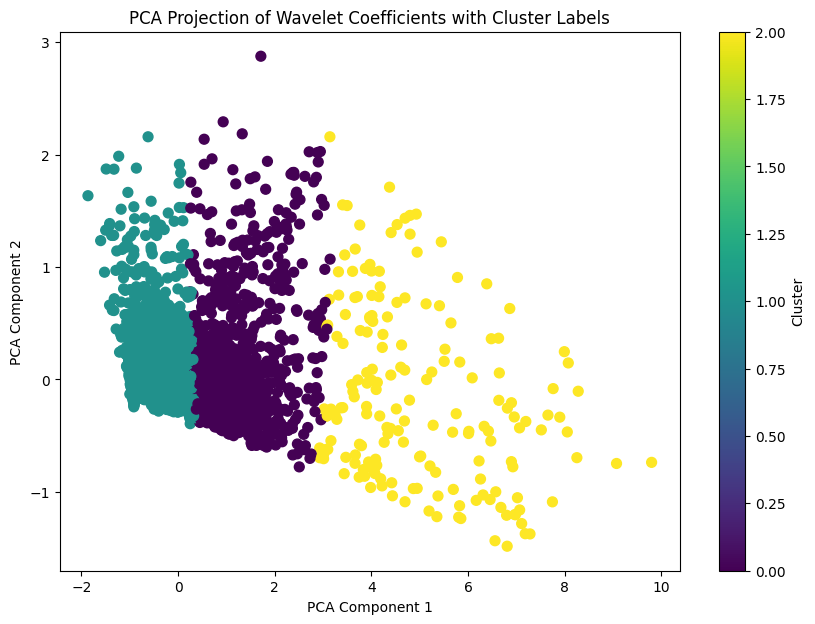

array([0.70322942, 0.06298914, 0.04724397])

In [22]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA를 사용하여 데이터를 2차원으로 축소
pca = PCA(n_components=3)
coeffs_pca = pca.fit_transform(coeffs_flat)

# 클러스터 결과를 2차원 공간에 시각화
plt.figure(figsize=(10, 7))
plt.scatter(coeffs_pca[:, 0], coeffs_pca[:, 1], c=labels, cmap='viridis', s=50)
plt.title('PCA Projection of Wavelet Coefficients with Cluster Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# PCA 설명력 (Variance Explained)
explained_variance = pca.explained_variance_ratio_
explained_variance

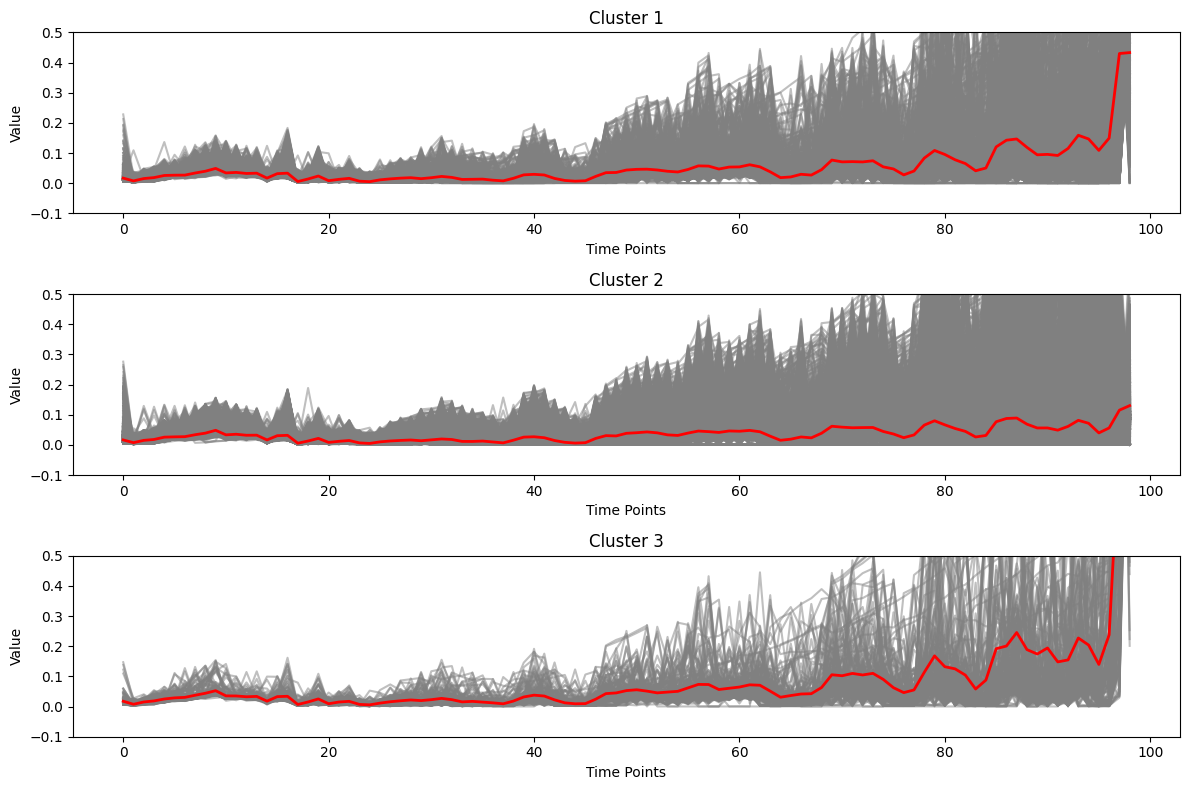

In [23]:
# 클러스터별 곡선 시각화
plt.figure(figsize=(12, 8))

for cluster in range(3):  # 각 클러스터에 대해 반복
    plt.subplot(3, 1, cluster + 1)
    for curve in curves_data[labels == cluster]:
        plt.plot(curve, color='gray', alpha=0.5)  # 개별 곡선
    plt.plot(curves_data[labels == cluster].mean(axis=0), color='red', linewidth=2)  # 평균 곡선
    plt.title(f'Cluster {cluster + 1}')
    plt.xlabel('Time Points')
    plt.ylabel('Value')
    plt.ylim(-0.1, 0.5)

plt.tight_layout()
plt.show()


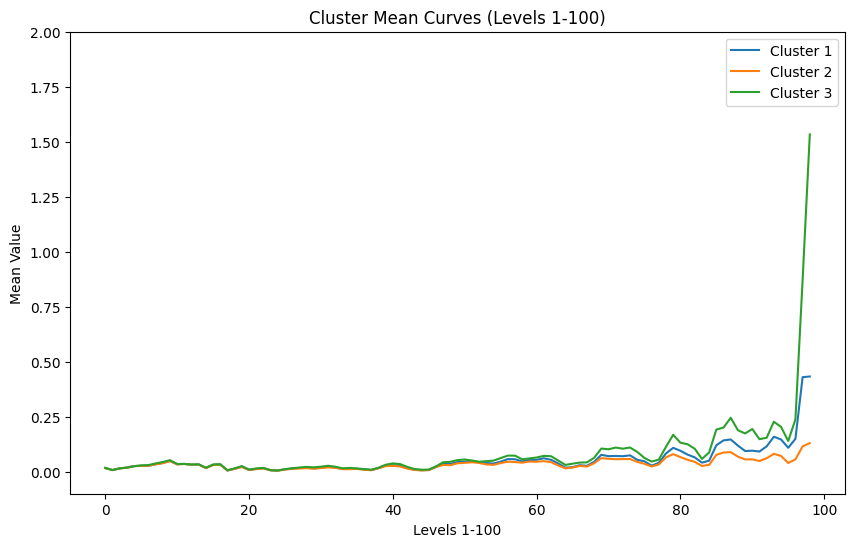

In [24]:
# 클러스터별 평균 곡선을 하나의 그래프로 시각화
plt.figure(figsize=(10, 6))

for cluster in range(3):  # 각 클러스터에 대해 반복
    mean_curve = curves_data[labels == cluster].mean(axis=0)
    plt.plot(mean_curve, label=f'Cluster {cluster + 1}')

plt.title('Cluster Mean Curves (Levels 1-100)')
plt.xlabel('Levels 1-100')
plt.ylabel('Mean Value')
plt.ylim(-0.1, 2)  # 필요시 Y축 범위 조정
plt.legend()
plt.show()

## Lv 50

In [25]:
# 웨이블릿 변환을 위한 데이터 선택 (2번 열부터 100번 열까지)
curves_data = data.iloc[:, 1:50].values  # 2번 열부터 100번 열까지 선택

# 각 곡선에 웨이블릿 변환 적용
coeffs = [pywt.wavedec(curve, 'db4', level=4) for curve in curves_data]
# 모든 웨이블릿 계수를 하나의 배열로 병합
coeffs_flat = np.array([np.concatenate(c) for c in coeffs])

# KMeans 클러스터링 수행
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(coeffs_flat)

# 클러스터 레이블을 원본 데이터에 추가
data['50_cluster'] = labels

c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


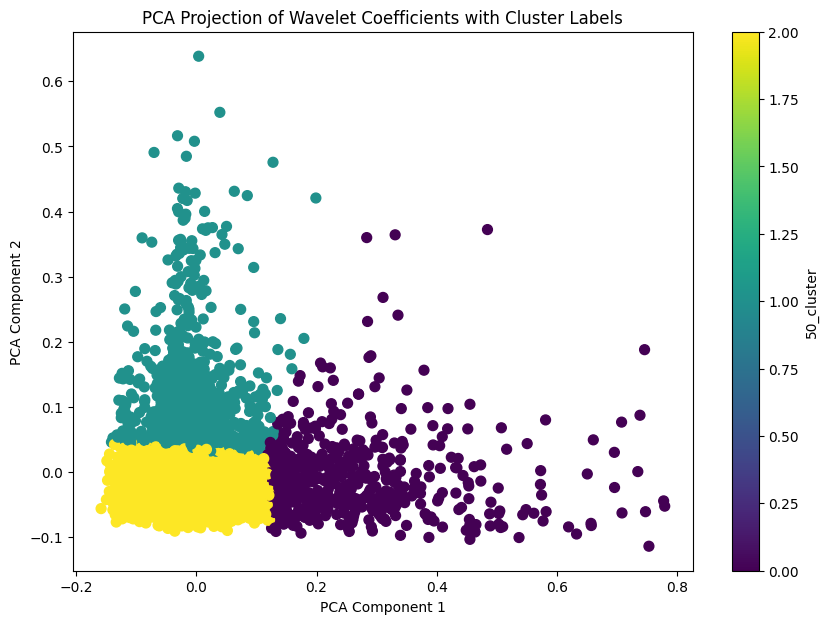

array([0.36002079, 0.17342246, 0.05508612])

In [28]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA를 사용하여 데이터를 2차원으로 축소
pca = PCA(n_components=3)
coeffs_pca = pca.fit_transform(coeffs_flat)

# 클러스터 결과를 2차원 공간에 시각화
plt.figure(figsize=(10, 7))
plt.scatter(coeffs_pca[:, 0], coeffs_pca[:, 1], c=labels, cmap='viridis', s=50)
plt.title('PCA Projection of Wavelet Coefficients with Cluster Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='50_cluster')
plt.show()

# PCA 설명력 (Variance Explained)
explained_variance = pca.explained_variance_ratio_
explained_variance

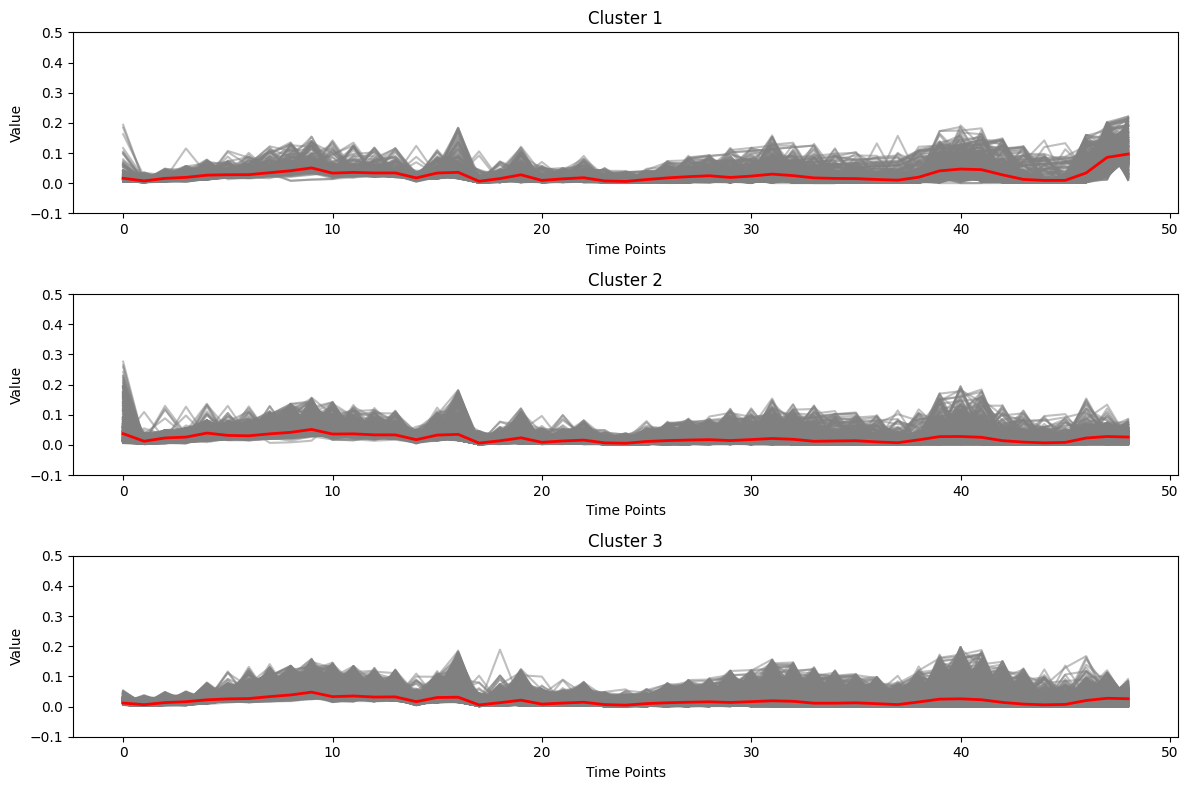

In [27]:
# 클러스터별 곡선 시각화
plt.figure(figsize=(12, 8))

for cluster in range(3):  # 각 클러스터에 대해 반복
    plt.subplot(3, 1, cluster + 1)
    for curve in curves_data[labels == cluster]:
        plt.plot(curve, color='gray', alpha=0.5)  # 개별 곡선
    plt.plot(curves_data[labels == cluster].mean(axis=0), color='red', linewidth=2)  # 평균 곡선
    plt.title(f'Cluster {cluster + 1}')
    plt.xlabel('Time Points')
    plt.ylabel('Value')
    plt.ylim(-0.1, 0.5)

plt.tight_layout()
plt.show()


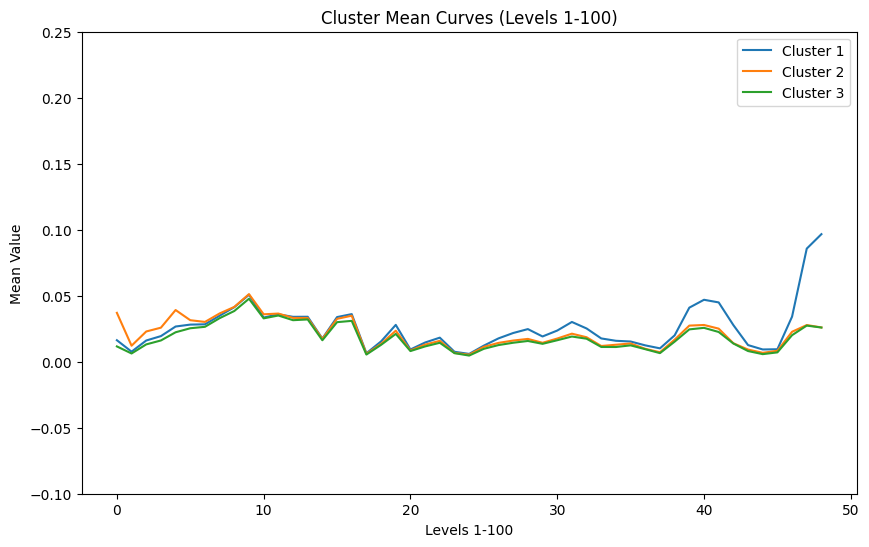

In [31]:
# 클러스터별 평균 곡선을 하나의 그래프로 시각화
plt.figure(figsize=(10, 6))

for cluster in range(3):  # 각 클러스터에 대해 반복
    mean_curve = curves_data[labels == cluster].mean(axis=0)
    plt.plot(mean_curve, label=f'Cluster {cluster + 1}')

plt.title('Cluster Mean Curves (Levels 1-100)')
plt.xlabel('Levels 1-100')
plt.ylabel('Mean Value')
plt.ylim(-0.1, 0.25)  # 필요시 Y축 범위 조정
plt.legend()
plt.show()

In [32]:
data

,player_slug,2,3,4,5,6,7,8,9,10,...,95,96,97,98,99,100,total_ad,total_purchase,cluster,50_cluster
0,2021-11-01T08:32:01.518Z,0.019444,0.004167,0.009444,0.015833,0.015278,0.020833,0.026667,0.034167,0.044722,...,0.152222,0.003333,0.003889,0.132667,0.906944,0.914500,0.0,0.0,2,2
1,2021-11-01T10:41:53.949Z,0.020556,0.004167,0.006111,0.006667,0.019722,0.021389,0.023056,0.030278,0.032778,...,0.095833,0.157500,0.002500,0.127944,0.401944,0.514722,28.0,0.0,0,2
2,2021-11-01T14:12:34.729Z,0.015833,0.004444,0.030278,0.013889,0.028056,0.020000,0.021389,0.026389,0.032778,...,0.064500,0.351111,0.041611,0.111389,0.002222,0.001944,0.0,0.0,1,2
3,2021-11-01T15:01:02.831Z,0.007778,0.003056,0.006389,0.009722,0.012500,0.049722,0.070833,0.036222,0.032500,...,0.236111,0.036111,0.002778,0.126667,0.121111,0.135556,0.0,0.0,1,2
4,2021-11-01T15:10:02.121Z,0.006944,0.003611,0.010833,0.015000,0.023056,0.022778,0.022500,0.048333,0.031667,...,0.199111,0.065222,0.024167,0.003333,0.070611,0.250556,2.0,3300.0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7274,2022-03-28T00:01:33.666Z,0.006667,0.003333,0.008333,0.013889,0.019444,0.021667,0.021111,0.024722,0.030278,...,0.090556,0.083333,0.002222,0.002222,0.036444,0.600833,2.0,3300.0,0,2
7275,2022-03-28T07:44:40.201Z,0.006944,0.003056,0.005833,0.012500,0.012500,0.021667,0.021389,0.027222,0.036944,...,0.759722,0.876389,0.136778,0.171667,0.043056,0.067500,0.0,0.0,1,2
7276,2022-03-28T11:06:23.113Z,0.006389,0.005278,0.012222,0.021944,0.031389,0.026667,0.024722,0.033889,0.035556,...,0.081389,0.080000,0.002778,0.002778,0.071167,0.149722,0.0,122100.0,1,2
7277,2022-03-29T09:29:33.653Z,0.031389,0.031111,0.047222,0.029722,0.037778,0.020556,0.023778,0.026111,0.032222,...,0.049167,0.002778,0.002778,0.023444,0.093333,0.102778,6.0,0.0,1,1


In [34]:
df_unique = binge_df.drop_duplicates(subset=['player_slug'])
df_unique
merged_df = data.merge(df_unique, on='player_slug', how='left')
merged_df
# Cluster별로 그룹화하여 'binge' 열의 비율을 계산
binge_ratios = merged_df.groupby('50_cluster')['binge'].value_counts(normalize=True).unstack()

# 결과 확인
print(binge_ratios)
binge_number = merged_df.groupby('50_cluster')['binge'].value_counts().unstack()

# 결과 확인
print(binge_number)

binge              0         1
50_cluster                    
0           0.482109  0.517891
1           0.491867  0.508133
2           0.483599  0.516401
binge          0     1
50_cluster            
0            256   275
1            635   656
2           2639  2818


## 50레벨 클러스터링 기반 예측

In [48]:
import pandas as pd
import numpy as np
import pywt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
data= pd.read_csv('full_lv100_0801_ad.csv',encoding='utf-8')

In [49]:
# 'ad'나 'purchase' 관련된 컬럼은 제외하고, 2번 열부터 100번 열까지 선택
irrelevant_columns = ['total_ad', 'total_purchase']
relevant_columns = [col for col in data.columns if col not in irrelevant_columns]
curves_data = data[relevant_columns].iloc[:, 1:100].values  # 2번 열부터 100번 열까지

# 특정 구간 선택 - 레벨 1~50과 51~100
selected_range_1_50 = slice(0, 50)
selected_range_51_100 = slice(50, 100)


In [50]:
# 웨이블릿 변환 함수 정의
def apply_wavelet(curve):
    coeffs = pywt.wavedec(curve, 'db4', level=4)
    return np.concatenate(coeffs)
# 레벨 1~50 데이터에 대해 웨이블릿 변환 적용
wavelet_curves_1_50 = np.array([apply_wavelet(curve[selected_range_1_50]) for curve in curves_data])

# 레벨 1~100 데이터에 대해 웨이블릿 변환 적용
wavelet_curves_1_100 = np.array([apply_wavelet(curve) for curve in curves_data])


c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


In [51]:
# KMeans 클러스터링 수행 (1~50 데이터)
kmeans_1_50 = KMeans(n_clusters=2, random_state=42)
labels_1_50 = kmeans_1_50.fit_predict(wavelet_curves_1_50)

# KMeans 클러스터링 수행 (1~100 데이터)
kmeans_1_100 = KMeans(n_clusters=2, random_state=42)
labels_1_100 = kmeans_1_100.fit_predict(wavelet_curves_1_100)


c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [52]:
# 레벨 1~50의 클러스터 레이블을 데이터프레임에 추가
data['cluster_1_50'] = labels_1_50


In [53]:
# 모델 훈련을 위한 데이터 준비
X = np.hstack((wavelet_curves_1_50, labels_1_50.reshape(-1, 1)))  # 레벨 1~50 웨이블릿 변환 데이터 + 클러스터 레이블
y = labels_1_100  # 레벨 1~100 클러스터 레이블


In [54]:
# 훈련/검증/테스트 데이터 분할
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# 랜덤 포레스트 모델 훈련
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 검증 데이터에 대해 예측 수행
y_valid_pred = model.predict(X_valid)

# 검증 데이터 예측 결과 평가
print("Validation Set Performance:")
print(classification_report(y_valid, y_valid_pred))

# 테스트 데이터에 대해 예측 수행
y_test_pred = model.predict(X_test)

# 테스트 데이터 예측 결과 평가
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))


Validation Set Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.93      1.00      0.96      1355

    accuracy                           0.93      1456
   macro avg       0.47      0.50      0.48      1456
weighted avg       0.87      0.93      0.90      1456

Test Set Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        81
           1       0.94      1.00      0.97      1375

    accuracy                           0.94      1456
   macro avg       0.47      0.50      0.49      1456
weighted avg       0.89      0.94      0.92      1456



c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [ ]:
# 전체 데이터에 대해 클러스터 예측 수행
predicted_clusters = model.predict(X)

# 예측된 클러스터 레이블을 데이터프레임에 추가
data['predicted_cluster_51_100'] = predicted_clusters

In [55]:
# 검증 세트에서 틀린 예측의 개수
incorrect_valid_predictions = np.sum(y_valid_pred != y_valid)
print(f"Number of incorrect predictions in validation set: {incorrect_valid_predictions}")

# 테스트 세트에서 틀린 예측의 개수
incorrect_test_predictions = np.sum(y_test_pred != y_test)
print(f"Number of incorrect predictions in test set: {incorrect_test_predictions}")

# 추가적으로 전체 틀린 예측 비율(오류율)도 계산할 수 있습니다.
error_rate_valid = incorrect_valid_predictions / len(y_valid)
error_rate_test = incorrect_test_predictions / len(y_test)

print(f"Validation set error rate: {error_rate_valid:.2f}")
print(f"Test set error rate: {error_rate_test:.2f}")

# 성능 평가
print("Validation Set Performance:")
print(classification_report(y_valid, y_valid_pred))

print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

Number of incorrect predictions in validation set: 101
Number of incorrect predictions in test set: 81
Validation set error rate: 0.07
Test set error rate: 0.06
Validation Set Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.93      1.00      0.96      1355

    accuracy                           0.93      1456
   macro avg       0.47      0.50      0.48      1456
weighted avg       0.87      0.93      0.90      1456

Test Set Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        81
           1       0.94      1.00      0.97      1375

    accuracy                           0.94      1456
   macro avg       0.47      0.50      0.49      1456
weighted avg       0.89      0.94      0.92      1456



c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [57]:
from lightgbm import LGBMClassifier

# LightGBM 모델 훈련
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)

# 검증 데이터에 대해 예측 수행
y_valid_pred_lgbm = lgbm_model.predict(X_valid)

# 검증 데이터 예측 결과 평가
print("Validation Set Performance (LightGBM):")
print(classification_report(y_valid, y_valid_pred_lgbm))

# 테스트 데이터에 대해 예측 수행
y_test_pred_lgbm = lgbm_model.predict(X_test)

# 테스트 데이터 예측 결과 평가
print("Test Set Performance (LightGBM):")
print(classification_report(y_test, y_test_pred_lgbm))


[LightGBM] [Info] Number of positive: 4120, number of negative: 247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19127
[LightGBM] [Info] Number of data points in the train set: 4367, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.943439 -> initscore=2.814220
[LightGBM] [Info] Start training from score 2.814220
Validation Set Performance (LightGBM):
              precision    recall  f1-score   support

           0       0.50      0.01      0.02       101
           1       0.93      1.00      0.96      1355

    accuracy                           0.93      1456
   macro avg       0.72      0.50      0.49      1456
weighted avg       0.90      0.93      0.90      1456

Test Set Performance (LightGBM):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        81
   

c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sunwoong\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [58]:
# 데이터 로드
data = pd.read_csv('levelups_panel_20240722.csv')


In [62]:
data

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_tower,playtime_pvp,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge
0,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,1,2,...,0.0,0.0,0.0,0.0,0.0,2021-11-04,2021-11-04,True,0.009444,1
1,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,2,3,...,0.0,0.0,0.0,0.0,0.0,2021-11-13,2021-11-04,False,5.426389,1
2,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,3,4,...,0.0,0.0,0.0,0.0,0.0,2021-11-13,2021-11-13,True,5.426389,1
3,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,4,5,...,0.0,0.0,0.0,0.0,0.0,2021-11-13,2021-11-13,True,5.426389,1
4,2021-10-31T16:01:57.631Z,킹덤,2,0,0.0,0.0,7,complete,5,6,...,0.0,0.0,0.0,0.0,0.0,2021-11-13,2021-11-13,True,5.426389,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466992,2022-03-30T14:36:22.522Z,킹키킹,8,0,0.0,0.0,8,complete,3,4,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,0.236667,0
2466993,2022-03-30T14:36:22.522Z,킹키킹,8,0,0.0,0.0,8,complete,4,5,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,0.236667,0
2466994,2022-03-30T14:36:22.522Z,킹키킹,8,0,0.0,0.0,8,complete,5,6,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,0.236667,0
2466995,2022-03-30T14:36:22.522Z,킹키킹,8,0,0.0,0.0,8,complete,6,7,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,0.236667,0


In [60]:
data.columns

Index(['player_slug', 'character_slug', 'first_session_level', 'binger',
       'total_purchase', 'total_ad', 'highest_level', 'status', 'level_from',
       'level_to', 'event_datetime', 'death', 'ad_revival', 'ad_item',
       'ad_total', 'purchase', 'event_datetime_prev', 'interval',
       'interval_cum', 'playtime_boss', 'playtime_dungeon', 'playtime_tower',
       'playtime_pvp', 'playtime_farm', 'playtime_survival', 'playtime_side',
       'date_event', 'date_event_prev', 'same_date', 'date_interval', 'binge'],
      dtype='object')

In [72]:
ad_avoid=data[(data['purchase']==3300)&(data['highest_level']>=100)]

In [71]:
ad_avoid['binger'].sum()

801

In [79]:
ad_avoid[(ad_avoid['purchase']==3300)&(ad_avoid['level_to']<=100)]

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_tower,playtime_pvp,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge
2002,2021-11-01T15:10:02.121Z,딸건,8,0,3300.0,2.0,115,complete,61,62,...,0.0,0.0,0.0,0.0,0.0,2021-11-07,2021-11-07,True,12.962500,1
2576,2021-11-01T19:58:43.096Z,느흐,85,1,3300.0,6.0,102,complete,11,12,...,0.0,0.0,0.0,0.0,0.0,2021-11-02,2021-11-02,True,14.566389,0
4080,2021-11-02T07:01:00.977Z,다올파파,78,1,3300.0,6.0,120,complete,8,9,...,0.0,0.0,0.0,0.0,0.0,2021-11-02,2021-11-02,True,5.929167,1
7714,2021-11-03T10:52:48.570Z,망뚝,16,0,3300.0,0.0,108,complete,10,11,...,0.0,0.0,0.0,0.0,0.0,2021-11-03,2021-11-03,True,1.058889,0
8658,2021-11-03T13:57:10.005Z,신권,125,1,66000.0,0.0,125,complete,75,76,...,0.0,0.0,0.0,0.0,0.0,2021-11-04,2021-11-04,True,20.598611,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459815,2022-03-24T16:37:29.569Z,쫑이,113,1,23100.0,11.0,173,complete,39,40,...,0.0,0.0,0.0,0.0,0.0,2022-03-25,2022-03-25,True,21.630833,1
2462319,2022-03-26T14:18:18.258Z,리뷰,101,1,14300.0,1.0,101,complete,62,63,...,0.0,0.0,0.0,0.0,0.0,2022-03-27,2022-03-27,True,16.748056,1
2463474,2022-03-27T10:35:57.394Z,윤주다,7,0,3300.0,1.0,100,complete,11,12,...,0.0,0.0,0.0,0.0,0.0,2022-03-27,2022-03-27,True,4.058611,0
2464365,2022-03-28T00:01:33.666Z,벤쿱,99,1,3300.0,2.0,103,complete,53,54,...,0.0,0.0,0.0,0.0,0.0,2022-03-28,2022-03-28,True,7.316667,1


In [80]:
data[(data['purchase']==3300)&(data['level_to']<=100)]

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_tower,playtime_pvp,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge
1091,2021-11-01T12:48:42.128Z,단풍,68,1,3300.0,1.0,99,complete,8,9,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,2.008611,0
2002,2021-11-01T15:10:02.121Z,딸건,8,0,3300.0,2.0,115,complete,61,62,...,0.0,0.0,0.0,0.0,0.0,2021-11-07,2021-11-07,True,12.962500,1
2576,2021-11-01T19:58:43.096Z,느흐,85,1,3300.0,6.0,102,complete,11,12,...,0.0,0.0,0.0,0.0,0.0,2021-11-02,2021-11-02,True,14.566389,0
3259,2021-11-02T04:05:29.150Z,순철,10,0,3300.0,0.0,51,complete,9,10,...,0.0,0.0,0.0,0.0,0.0,2021-11-02,2021-11-02,True,6.595278,1
4080,2021-11-02T07:01:00.977Z,다올파파,78,1,3300.0,6.0,120,complete,8,9,...,0.0,0.0,0.0,0.0,0.0,2021-11-02,2021-11-02,True,5.929167,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2464365,2022-03-28T00:01:33.666Z,벤쿱,99,1,3300.0,2.0,103,complete,53,54,...,0.0,0.0,0.0,0.0,0.0,2022-03-28,2022-03-28,True,7.316667,1
2464844,2022-03-28T11:06:23.113Z,구또,47,0,122100.0,0.0,124,complete,16,17,...,0.0,0.0,0.0,0.0,0.0,2022-03-28,2022-03-28,True,3.639167,1
2465118,2022-03-28T15:00:55.866Z,노빤스,20,0,3300.0,1.0,34,complete,20,21,...,0.0,0.0,0.0,0.0,0.0,2022-03-29,2022-03-29,True,11.970278,1
2465706,2022-03-29T07:51:25.065Z,폴로,17,0,36300.0,0.0,17,complete,8,9,...,0.0,0.0,0.0,0.0,0.0,2022-03-29,2022-03-29,True,0.600556,0


In [70]:
ad_avoid

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_tower,playtime_pvp,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge
2002,2021-11-01T15:10:02.121Z,딸건,8,0,3300.0,2.0,115,complete,61,62,...,0.0,0.0,0.0,0.0,0.0,2021-11-07,2021-11-07,True,12.962500,1
2576,2021-11-01T19:58:43.096Z,느흐,85,1,3300.0,6.0,102,complete,11,12,...,0.0,0.0,0.0,0.0,0.0,2021-11-02,2021-11-02,True,14.566389,0
4080,2021-11-02T07:01:00.977Z,다올파파,78,1,3300.0,6.0,120,complete,8,9,...,0.0,0.0,0.0,0.0,0.0,2021-11-02,2021-11-02,True,5.929167,1
7714,2021-11-03T10:52:48.570Z,망뚝,16,0,3300.0,0.0,108,complete,10,11,...,0.0,0.0,0.0,0.0,0.0,2021-11-03,2021-11-03,True,1.058889,0
8658,2021-11-03T13:57:10.005Z,신권,125,1,66000.0,0.0,125,complete,75,76,...,0.0,0.0,0.0,0.0,0.0,2021-11-04,2021-11-04,True,20.598611,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459815,2022-03-24T16:37:29.569Z,쫑이,113,1,23100.0,11.0,173,complete,39,40,...,0.0,0.0,0.0,0.0,0.0,2022-03-25,2022-03-25,True,21.630833,1
2462319,2022-03-26T14:18:18.258Z,리뷰,101,1,14300.0,1.0,101,complete,62,63,...,0.0,0.0,0.0,0.0,0.0,2022-03-27,2022-03-27,True,16.748056,1
2463474,2022-03-27T10:35:57.394Z,윤주다,7,0,3300.0,1.0,100,complete,11,12,...,0.0,0.0,0.0,0.0,0.0,2022-03-27,2022-03-27,True,4.058611,0
2464365,2022-03-28T00:01:33.666Z,벤쿱,99,1,3300.0,2.0,103,complete,53,54,...,0.0,0.0,0.0,0.0,0.0,2022-03-28,2022-03-28,True,7.316667,1


In [65]:
data[(data['purchase']>=3300)]

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_tower,playtime_pvp,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge
1091,2021-11-01T12:48:42.128Z,단풍,68,1,3300.0,1.0,99,complete,8,9,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,2.008611,0
1340,2021-11-01T13:52:32.587Z,샤에,11,0,19800.0,0.0,79,complete,12,13,...,0.0,0.0,0.0,0.0,0.0,2021-11-02,2021-11-02,True,0.207222,0
1342,2021-11-01T13:52:32.587Z,샤에,11,0,19800.0,0.0,79,complete,14,15,...,0.0,0.0,0.0,0.0,0.0,2021-11-02,2021-11-02,True,0.207222,0
2002,2021-11-01T15:10:02.121Z,딸건,8,0,3300.0,2.0,115,complete,61,62,...,0.0,0.0,0.0,0.0,0.0,2021-11-07,2021-11-07,True,12.962500,1
2576,2021-11-01T19:58:43.096Z,느흐,85,1,3300.0,6.0,102,complete,11,12,...,0.0,0.0,0.0,0.0,0.0,2021-11-02,2021-11-02,True,14.566389,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2465706,2022-03-29T07:51:25.065Z,폴로,17,0,36300.0,0.0,17,complete,8,9,...,0.0,0.0,0.0,0.0,0.0,2022-03-29,2022-03-29,True,0.600556,0
2465712,2022-03-29T07:51:25.065Z,폴로,17,0,36300.0,0.0,17,complete,14,15,...,0.0,0.0,0.0,0.0,0.0,2022-03-29,2022-03-29,True,0.600556,0
2466245,2022-03-30T05:37:49.026Z,백야행,21,0,49500.0,0.0,30,complete,9,10,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.683889,1
2466260,2022-03-30T05:37:49.026Z,백야행,21,0,49500.0,0.0,30,complete,24,25,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.683889,1
